# FX NET
models raw audio directly through multi-layered convolutional network

model built with inspiration from wavenet https://arxiv.org/pdf/1609.03499.pdf

and https://github.com/tomlepaine/fast-wavenet

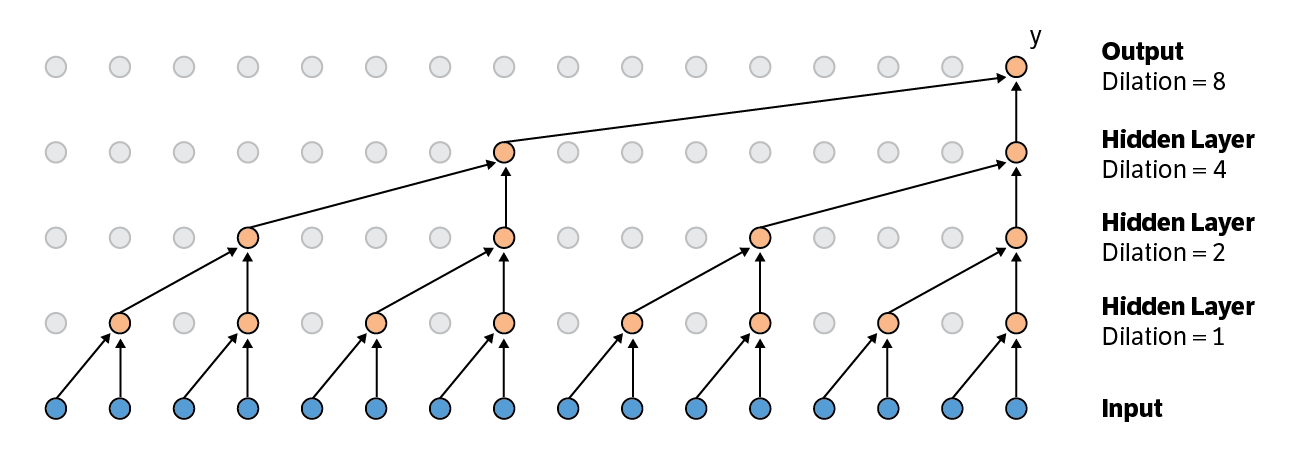




idea for architecture: cache states in the graph, for less computation (O(l) instead of O(2^l)

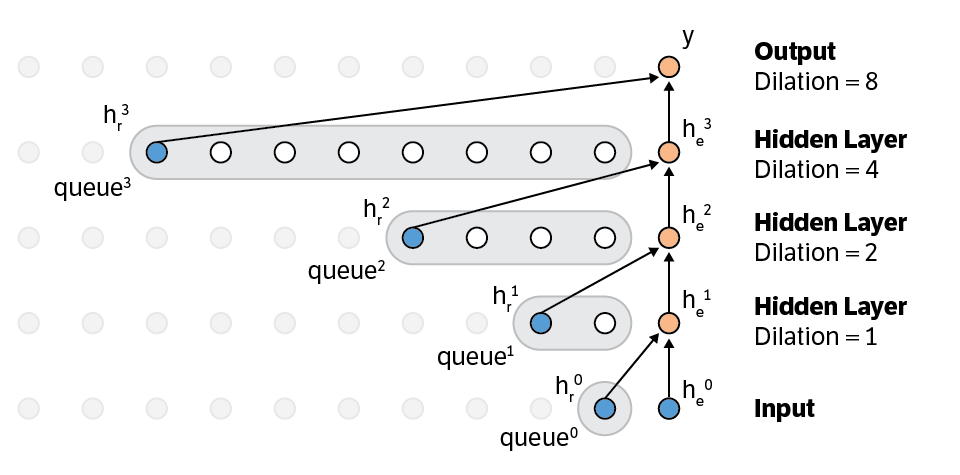

### PROBLEM: generation is waaaayyy too slow (fast-wavenet takes >160 seconds for 1 sec of audio)

maybe just use some parts? let's start with incorporating raw audio

In [1]:
%matplotlib inline
import math
import pywt
# import tables
import pandas as pd
# import inspect
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, Activation, Input, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, Concatenate
# import keras as K
# from keras.layers import concatenate as kconcat
# from keras.layers import LSTM
import scipy.io.wavfile as wavfile
from sklearn.decomposition import PCA
# from scipy.interpolate import interp1d

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
input_rate, input_signal = wavfile.read('data/3songs/3songs_no_fx.wav')
output_rate, output_signal = wavfile.read('data/3songs/3songs_overdrive_util.wav')

## Data Processing
TODO: determine window size, data handling (hdf5? generator? separate processing and intermediate storage?)

In [3]:
print(input_signal[0:10,0])
print(input_signal[0:10,1])

mono_raw_in = np.ndarray.flatten(input_signal,'F')
print(mono_raw_in[0:20])
testie1 = [np.zeros(3),np.ones(3),np.zeros(3)]
print(testie1)
testie2 = np.ndarray.flatten(np.asarray(testie1))
print(testie2)
print(np.concatenate((testie2,testie2)))

[ 0  0  0 -1 -4  1 16 26 23 17]
[ 0  0  1  0 -2  4 17 24 19 11]
[ 0  0  0 -1 -4  1 16 26 23 17 14 19 29 33 32 42 53 61 71 62]
[array([0., 0., 0.]), array([1., 1., 1.]), array([0., 0., 0.])]
[0. 0. 0. 1. 1. 1. 0. 0. 0.]
[0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]


steps:
- split original input into stereo chunks
- for each channel, get wavelet decomp
- concatenate channels and wavelet data for both channels
    - create functions for both transforming encoding and decoding
- create input sequences (padding? length?)

In [4]:
# for a stereo audio slice
# concat the raw audio with the wavelet transform, concat l+r
def audio_to_vector(input_raw, wavelet_level, wavelet_type, info=False):
#     coeffs = pywt.wavedec(input_mono, wavelet_type, level=wavelet_level)
#     vector = np.concatenate(coeffs)
    left_raw = input_raw[:,0]
    right_raw = input_raw[:,1]
    left_coeffs = pywt.wavedec(left_raw, wavelet_type, level=wavelet_level)
    right_coeffs = pywt.wavedec(right_raw, wavelet_type, level=wavelet_level)
    
    # concat left and right channel, and all the levels of coeffs
    left_coeffs_flat = np.concatenate(left_coeffs)
    right_coeffs_flat = np.concatenate(right_coeffs)
    
    total_left = np.concatenate((left_raw, left_coeffs_flat))
    total_right = np.concatenate((right_raw, left_coeffs_flat))
    
    if info:
        print("raw length: " + str(np.shape(left_raw)[0]))
        coeff_lengths = [len(coeff) for coeff in left_coeffs]
        flat_length = np.shape(left_coeffs_flat)
        print("shape coeffs: " + str(coeff_lengths) + " \nflat coeff length: " + str(flat_length))
        print("total length (1 channel): " + str(np.shape(total_left)))
    
    return np.concatenate((total_left, total_right))

In [5]:
# returns raw mono audio slice for dwt part of output 
output_coeff_lengths = [317, 317, 616, 1214, 2409]
output_coeff_ends = [317, 634, 1250, 2464, 4873]
def vector_to_mono_slice(input_vector):
    coeffs = np.split(input_vector, output_coeff_ends[:-1])
#     i = 0
#     for c_length in output_coeff_lengths:
        
#     print("coeff shape: " + str([coeff.shape for coeff in coeffs]))
    return np.array([pywt.waverec(coeffs, 'db10')]).astype('int16')

In [6]:
# multiple predicted samples to mono audio (pass in only dwt)
def prediction_to_mono(dwt_prediction):
    output_list = []
    for i in range(dwt_prediction.shape[0]):
        output_list.append(vector_to_mono_slice(dwt_prediction[i,:]))
    return np.concatenate(output_list,axis=1).astype('int16').T

In [7]:
# # TEST TEST
# dwt_recons = prediction_to_mono(exp_predictions[:,4800:])
# print(dwt_recons.shape)

# # output wav for auditory test
# wavfile.write('output/recons_FXNet1_dwt.wav', input_rate, dwt_recons)

In [8]:
# break synthesis up into 2 distinct areas, experiment recombination later
# input is just one channel! prediction and reconstruction for both channels separately
def vector_to_audio(input_vec, raw_length):
    raw_pred = input_vec[:raw_length]
    dwt_pred = input_vec[raw_length:]
    return raw_pred, dwt_pred

raw length: 4800
shape coeffs: [317, 317, 616, 1214, 2409] 
flat coeff length: (4873,)
total length (1 channel): (9673,)
(19346,)
---------
at 48000 Hz, 16 bit, 2 channels
total input shape: (19200000, 2)
duration: 400.0 sec


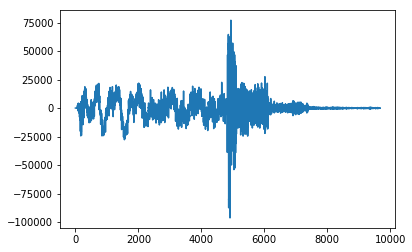

In [9]:
test_audio_stereo = input_signal[0:4800,:]
test_vec = audio_to_vector(test_audio_stereo, 4, 'db10', info=True)
print(np.shape(test_vec))
print("---------")

print("at 48000 Hz, 16 bit, 2 channels")
print("total input shape: " + str(np.shape(input_signal)))
print("duration: " + str(np.shape(input_signal)[0]/48000.) + " sec")

# plot some
fig, ax = plt.subplots()
ax.plot(test_vec[0:9673])

In [10]:
input_length_sec = 2.0 # 2 s
output_length_sec = 0.1 # 100 ms
sample_rate = 48000

input_sample_length = int(input_length_sec * sample_rate)
output_sample_length = int(output_length_sec * sample_rate)
print(input_sample_length, output_sample_length)

96000 4800


overlap? maybe later, better dwt on long sample -> more accuracy?
or go back to lstm, incorporate previous prediction in input?

for now, sliding window with step output_sample_length
so every output is new, every input has 1.9 sec overlap

INFO:

2 seconds

raw length: 96000

shape coeffs: [6017, 6017, 12016, 24014, 48009] 

flat coeff length: (96073,)

total length (1 channel): (192073,)

(384146,)

===========================================

0.1 sec

raw length: 4800

shape coeffs: [317, 317, 616, 1214, 2409] 

end indices: [317, 634, 1250, 2464, 4873]

flat coeff length: (4873,)

total length (1 channel): (9673,)

(19346,)



In [11]:
# del(output_list)
# output_list = []

In [12]:
print(pywt.wavelist(kind='discrete'))

total_samples = np.shape(output_signal)[0]
number_of_instances = total_samples/output_sample_length
print(number_of_instances)


load_data = True

if load_data:
    input_array = np.load('data/3songs/3songs_input_firsthalf.npy')
    output_array = np.load('data/3songs/3songs_output_overdrive_util_firsthalf.npy')
else:
    input_array, output_array = data_crunch_2()

# V1
def data_crunch_1():
    input_array = []
    output_array = []

    # take only first half of samples due to RAM limit
    for i in range(0, (total_samples/2)-input_sample_length, output_sample_length):
        end_output = i+input_sample_length
        input_stereo = input_signal[i:end_output,:]
        start_output = end_output - output_sample_length
        output_stereo = output_signal[start_output:end_output,:]

        input_vec = audio_to_vector(input_stereo, 4, 'db10')
        output_vec = audio_to_vector(output_stereo, 4, 'db10')

    #     input_dataframe = input_dataframe.append({'DATA': input_vec}, ignore_index=True)
    #     output_dataframe = output_dataframe.append({'DATA': output_vec}, ignore_index=True)
        input_array.append(input_vec)
        output_array.append(output_vec)

        print(str(i/output_sample_length) + "/" + str(number_of_instances))
    
    return np.array(input_array), np.array(output_array)


# V2
def data_crunch_2():
    input_array = []
    output_array = []

    # take only first half of samples due to RAM limit
    for i in range(0, (total_samples/2)-input_sample_length, output_sample_length):
        end_output = i+input_sample_length
        input_stereo = input_signal[i:end_output,:]
        start_output = end_output - output_sample_length
        output_stereo = output_signal[start_output:end_output,:]

        input_vec = audio_to_vector(input_stereo, 4, 'db10')
        output_vec = audio_to_vector(output_stereo, 4, 'db10')

    #     input_dataframe = input_dataframe.append({'DATA': input_vec}, ignore_index=True)
    #     output_dataframe = output_dataframe.append({'DATA': output_vec}, ignore_index=True)
        input_array.append(input_vec)
        output_array.append(output_vec)

        print(str(i/output_sample_length) + "/" + str(number_of_instances))
    
    return np.array(input_array), np.array(output_array)

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']
4000.0


In [13]:
# input_dataframe.to_pickle('3songs_input.pkl')
# output_dataframe.to_pickle('3songs_output.pkl')


In [14]:
# input_dataframe = pd.read_pickle('data/3songs/3songs_input.pkl')
# output_dataframe = pd.read_pickle('data/3songs/3songs_output_overdrive_util.pkl')
a = np.array([1,3,5,2,4])
b = np.array([7,3,23,2,1])
c = []
c.append(a)
c.append(b)
print(np.array(c))
# np.save('data/3songs/3songs_input_firsthalf', input_array)
# np.save('data/3songs/3songs_output_overdrive_util_firsthalf', output_array)

[[ 1  3  5  2  4]
 [ 7  3 23  2  1]]


## misschien was dataframe toch niet zo handig... keras wil een matrix...

In [15]:
# in_sample = input_dataframe.sample()
# print(np.shape(in_sample))
# input_dataframe.size
# input_dataframe.keys

# cnt = 0
# for index, row in input_dataframe.iterrows():
#     if cnt > 10:
#         break
#     print(row['DATA'])
#     print(input_dataframe.iloc[index].values[0])
#     print('------------------------------')
#     cnt += 1
    
print(input_array.shape)
print(output_array.shape)

# normalize? let's get some info
print(np.amax(input_array))
print(np.amin(input_array))
print(np.mean(input_array))
print(np.median(input_array))

(1980, 384146)
(1980, 19346)
155466.06968579657
-152486.81539229263
-6.649932211221621
0.0


In [16]:
output_to_image = False

if output_to_image:
    img = Image.fromarray(output_array)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img.save('my.png')
    img.show()

In [17]:
# check if data distribution is different between raw and dwt
# print(np.amax(output_array[:,:19346/4]))
# print(np.amin(output_array[:,:19346/4]))
# print(np.mean(output_array[:,:19346/4]))
# print(np.median(output_array[:,:19346/4]))
# print("^ raw .... dwt v")
# print(np.amax(output_array[:,16000:]))
# print(np.amin(output_array[:,16000:]))
# print(np.mean(output_array[:,16000:]))
# print(np.median(output_array[:,16000:]))
# left and right channels- [:,:19346/2] en [:,19346/2:]  (9673)
# for input 384146/2 (192073)

In [18]:
384146/2

192073.0

## Model Setup
TODO: find way to store cache (recurrent states)

for each timestep we need to pop and push from each layer's queue

288109.5
14509.5


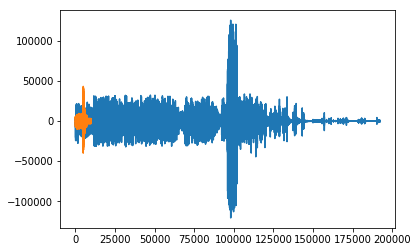

In [19]:
# del exp_model1
print(384146*0.75)
print(19346 * 0.75)

# plot one channel:
fig, ax = plt.subplots()
ax.plot(input_array[0,:192073])
ax.plot(output_array[0,:9673])

In [20]:
# set to one channel
input_cap = 192073
output_cap = 9673

exp_input1 = Input(shape=(input_cap,), dtype='float32', name='exp_input1')

# dense path
dense1 = Dense(600, activation='relu')(exp_input1)
drop1 = Dropout(0.2)(dense1)
dense2 = Dense(800, activation='relu')(drop1)
drop2 = Dropout(0.2)(dense2)
dense3 = Dense(500, activation='relu')(drop2)
drop3 = Dropout(0.2)(dense3)
dense4 = Dense(500, activation='relu')(drop3)
drop4 = Dropout(0.2)(dense3)

# another path
dense5 = Dense(200, activation='relu')(exp_input1)

added = Concatenate()([drop4, dense5])

# conv path
# conv1 = Convolution1D(filters=5, kernel_size=30)(exp_input1)


main_output = Dense(output_cap, activation='linear', name='main_output')(added)

exp_model1 = Model(inputs=[exp_input1], outputs=[main_output])

exp_model1.compile(optimizer='rmsprop', loss='mse')

# conv_model.fit(seq_added_dim, next_as_mat, batch_size=128, epochs=80)
exp_model1.summary()

# total data sizes:
# (1980, 384146)
# (1980, 19346)
# one channel: 192073, 9673
# 75% (kinda useless, takes raw part of other channel): 288109, 14509

exp_model1.fit(input_array[:,:input_cap], output_array[:,:output_cap], batch_size=80, epochs=50)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
exp_input1 (InputLayer)          (None, 192073)        0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 600)           115244400                                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 600)           0                                            
______________________________________________________________________

In [21]:
# predict

exp_predictions = exp_model1.predict(input_array[:,:input_cap])
exp_reconstruction_array = []
for i in range(exp_predictions.shape[0]):
    # working with raw so no inverse dwt
#     coeffs = vector_to_list(exp_predictions[i,:])
#     rec_arr = np.array([pywt.waverec(coeffs, wavetype)]).astype('int16')
    exp_reconstruction_array.append(exp_predictions[i,0:4800])

print("reconstruction done")

exp_reconstruction_array = np.concatenate(exp_reconstruction_array).astype('int16')
print(exp_reconstruction_array.shape)

# output wav for auditory test
wavfile.write('output/recons_FXNet1_raw.wav', input_rate, exp_reconstruction_array)

reconstruction done
(9504000,)


In [22]:
# now listen to dwt output part

dwt_recons = prediction_to_mono(exp_predictions[:,4800:])
print(dwt_recons.shape)

# output wav for auditory test
wavfile.write('output/recons_FXNet1_dwt.wav', input_rate, dwt_recons)

/usr/local/lib/python3.5/dist-packages/pywt/_multilevel.py:148: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a = a[[slice(s) for s in d.shape]]


(9504000, 1)


In [23]:
print(exp_predictions.shape)
print(exp_reconstruction_array.shape)

(1980, 9673)
(9504000,)


In [24]:
# for test purposes, write original output aswavs too
write_test_wavs = False

if write_test_wavs:
    exp_predictions = output_array[:,:output_cap]
    exp_reconstruction_array = []
    for i in range(exp_predictions.shape[0]):
        # working with raw so no inverse dwt
    #     coeffs = vector_to_list(exp_predictions[i,:])
    #     rec_arr = np.array([pywt.waverec(coeffs, wavetype)]).astype('int16')
        exp_reconstruction_array.append(exp_predictions[i,0:4800])


    exp_reconstruction_array = np.concatenate(exp_reconstruction_array).astype('int16')
    print(exp_reconstruction_array.shape)

    # output wav for auditory test
    wavfile.write('output/recons_FXNet1_input.wav', input_rate, exp_reconstruction_array)

    dwt_recons = prediction_to_mono(exp_predictions[:,4800:])
    print(dwt_recons.shape)

    # output wav for auditory test
    wavfile.write('output/recons_FXNet1_input_dwt.wav', input_rate, dwt_recons)

In [25]:
print(exp_predictions.shape)
print(exp_reconstruction_array.shape)
print(input_signal.dtype)
# output coeff indices:
old_j = 0
for j in [317, 317, 616, 1214, 2409]:
    old_j += j
    print(old_j)
output_coeff_lengths

(1980, 9673)
(9504000,)
int16
317
634
1250
2464
4873


[317, 317, 616, 1214, 2409]

## DIMENSIONALITY REDUCTION

In [26]:
# EXPENSIVE! re-work data, left and right sequentially, then apply PCA.
# pca = PCA(n_components=100000)
# pca.fit(input_array)